In [49]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold
import numpy as np

In [50]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 20
NUM_CLASSES = 17
k_folds = 4

In [51]:
# Load Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant_images",  # Path to your dataset
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6933 files belonging to 17 classes.


In [52]:
# Dataset Partition Function
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [53]:
# Split Dataset
train_ds, val_ds, test_ds = get_dataset_partitions_tf(
    dataset, train_split=0.6, val_split=0.2, test_split=0.2
)

In [54]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [55]:
# Apply batching and prefetching
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [56]:
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),  # Dropout added after last pooling layer
        
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),  # Dropout before the final classification layer
        layers.Dense(num_classes, activation='softmax'),
    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model


In [57]:
# K-Fold Cross-Validation
def prepare_numpy_data(dataset):
    images, labels = [], []
    for image, label in dataset.unbatch():
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

X, y = prepare_numpy_data(dataset)

In [58]:
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_accuracies = []
history_per_fold = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nProcessing Fold {fold + 1}/{k_folds}...")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_fold_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
    val_fold_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)

    model = create_model((IMAGE_SIZE, IMAGE_SIZE, CHANNELS), NUM_CLASSES)
    history = model.fit(train_fold_ds, epochs=EPOCHS, validation_data=val_fold_ds)
    history_per_fold.append(history.history)

    _, accuracy = model.evaluate(val_fold_ds)
    fold_accuracies.append(accuracy)
    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")


Processing Fold 1/4...
Epoch 1/20
163/163 [==============================] - 72s 429ms/step - loss: 3.0281 - accuracy: 0.1262 - val_loss: 2.4485 - val_accuracy: 0.2261
Epoch 2/20
163/163 [==============================] - 69s 424ms/step - loss: 2.2550 - accuracy: 0.2500 - val_loss: 1.8364 - val_accuracy: 0.3922
Epoch 3/20
163/163 [==============================] - 70s 428ms/step - loss: 1.9436 - accuracy: 0.3351 - val_loss: 1.5068 - val_accuracy: 0.4683
Epoch 4/20
163/163 [==============================] - 68s 417ms/step - loss: 1.7579 - accuracy: 0.4012 - val_loss: 1.5149 - val_accuracy: 0.5271
Epoch 5/20
163/163 [==============================] - 67s 414ms/step - loss: 1.5117 - accuracy: 0.4818 - val_loss: 1.0951 - val_accuracy: 0.6326
Epoch 6/20
163/163 [==============================] - 67s 413ms/step - loss: 1.3342 - accuracy: 0.5378 - val_loss: 1.2865 - val_accuracy: 0.5692
Epoch 7/20
163/163 [==============================] - 67s 413ms/step - loss: 1.1416 - accuracy: 0.6142 - v

In [59]:
# Average Accuracy
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f"\nAverage Accuracy over {k_folds} Folds: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")


Average Accuracy over 4 Folds: 0.8790
Standard Deviation of Accuracy: 0.0269


In [60]:
# Final Testing on the Test Set
final_model = create_model((IMAGE_SIZE, IMAGE_SIZE, CHANNELS), NUM_CLASSES)
final_history = final_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
_, test_accuracy = final_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/20
130/130 [==============================] - 68s 485ms/step - loss: 3.1585 - accuracy: 0.0848 - val_loss: 2.5738 - val_accuracy: 0.1399
Epoch 2/20
130/130 [==============================] - 62s 463ms/step - loss: 2.4992 - accuracy: 0.1762 - val_loss: 2.2137 - val_accuracy: 0.2718
Epoch 3/20
130/130 [==============================] - 63s 470ms/step - loss: 2.2742 - accuracy: 0.2315 - val_loss: 1.8436 - val_accuracy: 0.3245
Epoch 4/20
130/130 [==============================] - 60s 444ms/step - loss: 2.0898 - accuracy: 0.2748 - val_loss: 1.7856 - val_accuracy: 0.3350
Epoch 5/20
130/130 [==============================] - 60s 450ms/step - loss: 1.9000 - accuracy: 0.3165 - val_loss: 1.5217 - val_accuracy: 0.4601
Epoch 6/20
130/130 [==============================] - 62s 463ms/step - loss: 1.7264 - accuracy: 0.3764 - val_loss: 1.3866 - val_accuracy: 0.4927
Epoch 7/20
130/130 [==============================] - 61s 453ms/step - loss: 1.5845 - accuracy: 0.4452 - val_loss: 1.1354 - val_ac

In [61]:
import matplotlib.pyplot as plt

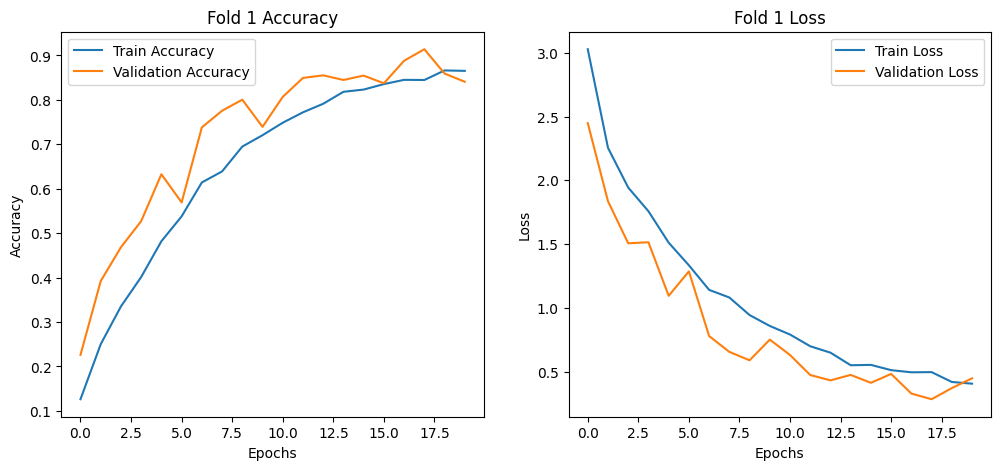

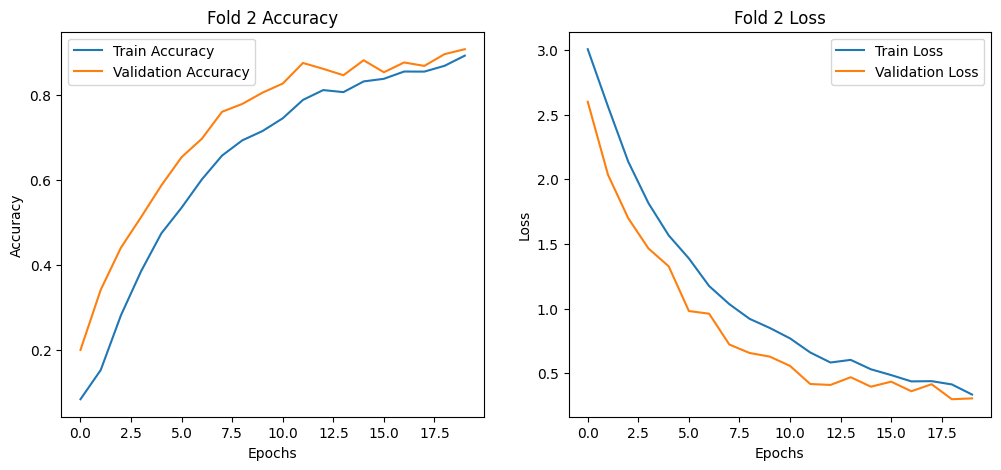

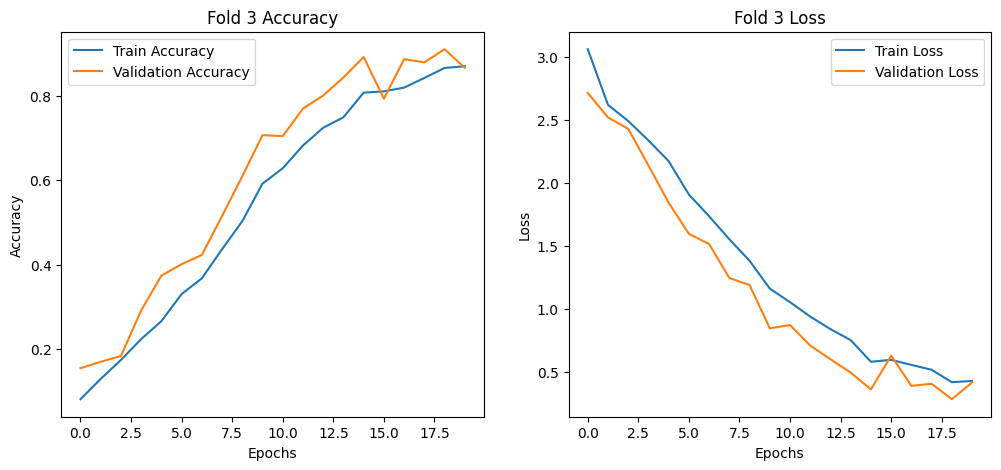

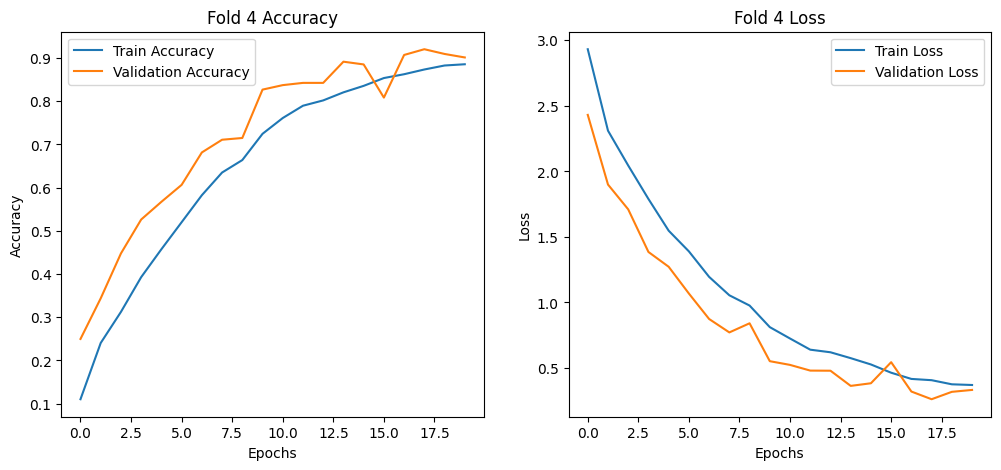

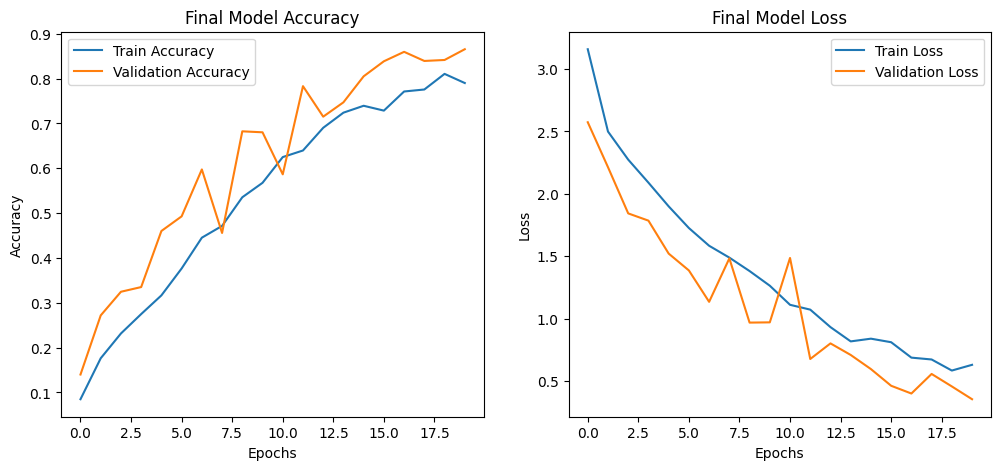

In [62]:
# Plotting the Results
def plot_metrics(history, title_prefix=""):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f"{title_prefix} Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the metrics for each fold
for i, history in enumerate(history_per_fold, start=1):
    plot_metrics(history, title_prefix=f"Fold {i}")

# Plot the metrics for the final model
plot_metrics(final_history.history, title_prefix="Final Model")




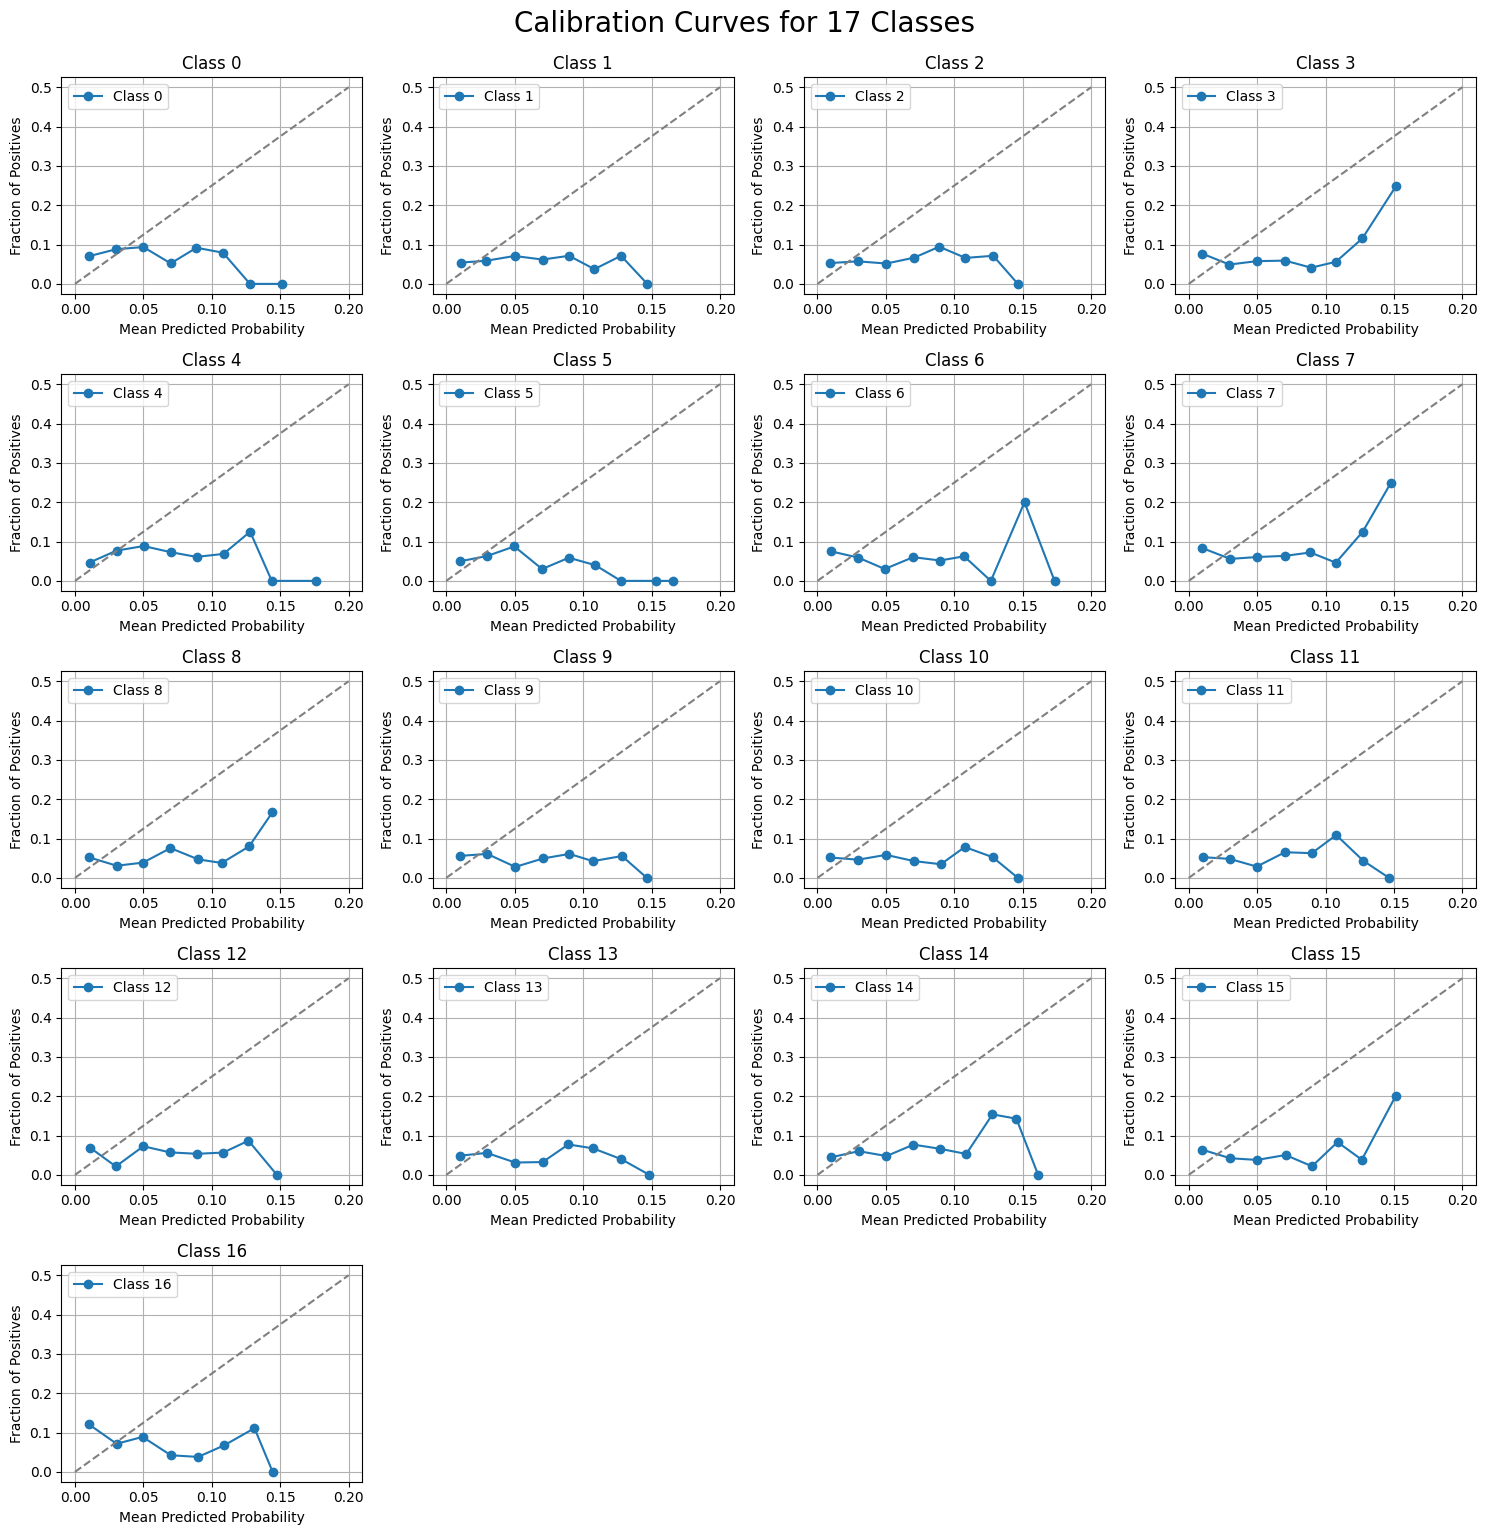

In [82]:
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize true labels (one-vs-rest)
y_val_bin = label_binarize(y_val_true, classes=np.arange(NUM_CLASSES))

# Setup for subplots
num_classes_to_plot = 17
rows, cols = 5, 4
fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
axs = axs.flatten()

for class_idx in range(num_classes_to_plot):
    true_bin = y_val_bin[:, class_idx]
    prob_class = y_val_probs[:, class_idx]  # Softmax probs for class_idx

    ax = axs[class_idx]

    if np.sum(true_bin) == 0:
        ax.set_title(f'Class {class_idx} (No positives)')
        ax.axis('off')
        continue

    # Calibration curve (no binarization or thresholding)
    prob_true, prob_pred_mean = calibration_curve(true_bin, prob_class, n_bins=50)

    ax.plot(prob_pred_mean, prob_true, marker='o', label=f'Class {class_idx}')
    ax.plot([0, 0.2], [0, 0.5], linestyle='--', color='gray')  # Ideal line
    ax.set_title(f'Class {class_idx}')
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.grid(True)
    ax.legend()

# Turn off unused plots
for i in range(num_classes_to_plot, len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.suptitle("Calibration Curves for 17 Classes", fontsize=20, y=1.02)
plt.show()



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


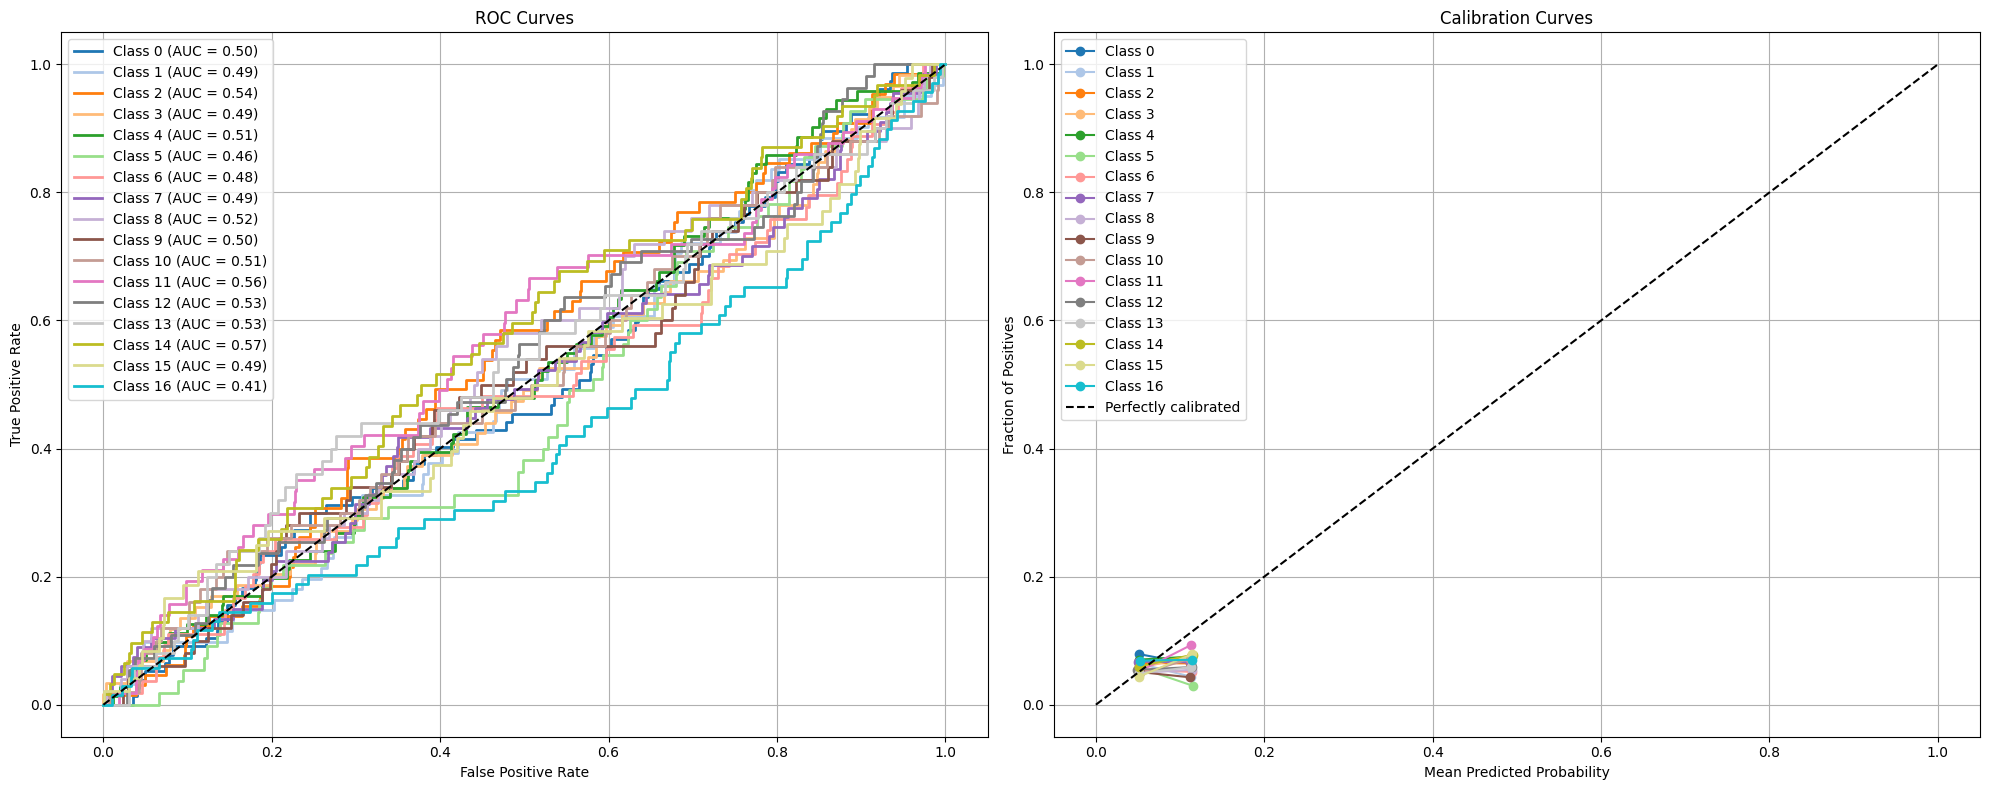


Class-wise Performance Metrics:
|   Class |    AUC |   Brier Score |    ECE | Calibration   |
|--------:|-------:|--------------:|-------:|:--------------|
|       0 | 0.4974 |        0.0726 | 0.0301 | Excellent     |
|       1 | 0.4926 |        0.0585 | 0.0189 | Excellent     |
|       2 | 0.5393 |        0.0614 | 0.0181 | Excellent     |
|       3 | 0.4921 |        0.0567 | 0.0104 | Excellent     |
|       4 | 0.513  |        0.067  | 0.0218 | Excellent     |
|       5 | 0.4606 |        0.0536 | 0.0139 | Excellent     |
|       6 | 0.4833 |        0.0525 | 0.0105 | Excellent     |
|       7 | 0.4925 |        0.0638 | 0.0209 | Excellent     |
|       8 | 0.5238 |        0.0484 | 0.0084 | Excellent     |
|       9 | 0.5008 |        0.0487 | 0.0093 | Excellent     |
|      10 | 0.5114 |        0.0486 | 0.0087 | Excellent     |
|      11 | 0.5609 |        0.0542 | 0.0031 | Excellent     |
|      12 | 0.5284 |        0.0528 | 0.0116 | Excellent     |
|      13 | 0.5343 |        0.0484 | 

In [83]:
# Install required packages
!pip install seaborn tabulate --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, brier_score_loss, confusion_matrix
from tabulate import tabulate

# ========== REPLACE THESE WITH YOUR ACTUAL OUTPUTS ==========
NUM_CLASSES = 17
num_classes_to_plot = NUM_CLASSES

# Sample placeholder data (replace with your real validation labels and probabilities)
np.random.seed(42)
y_val_true = np.random.randint(0, NUM_CLASSES, size=1000)  # Replace with real labels
y_val_probs = np.random.random((1000, NUM_CLASSES))        # Replace with calibrated probs
y_val_probs = y_val_probs / y_val_probs.sum(axis=1, keepdims=True)

# ========== Binarize Labels ==========
y_val_bin = label_binarize(y_val_true, classes=np.arange(NUM_CLASSES))


# ========== ECE Function ==========
def compute_ece(y_true, y_prob, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(y_prob > bin_lower, y_prob <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(y_true[in_bin])
            avg_confidence_in_bin = np.mean(y_prob[in_bin])
            ece += np.abs(accuracy_in_bin - avg_confidence_in_bin) * prop_in_bin
    return ece

# ========== Metrics Storage ==========
fpr, tpr, roc_auc = {}, {}, {}
brier_scores, ece_per_class = {}, {}

# ========== ROC, AUC, Brier, ECE ==========
for class_idx in range(num_classes_to_plot):
    true_bin = y_val_bin[:, class_idx]
    prob_pred = y_val_probs[:, class_idx]
    
    if np.sum(true_bin) == 0:
        continue  # Skip class with no positives

    fpr[class_idx], tpr[class_idx], _ = roc_curve(true_bin, prob_pred)
    roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])
    brier_scores[class_idx] = brier_score_loss(true_bin, prob_pred)
    ece_per_class[class_idx] = compute_ece(true_bin, prob_pred)

# ========== ROC and Calibration Curves ==========
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# ROC Curve
for class_idx in roc_auc.keys():
    color = plt.get_cmap('tab20')(class_idx / num_classes_to_plot)
    axes[0].plot(fpr[class_idx], tpr[class_idx], color=color, lw=2,
                 label=f'Class {class_idx} (AUC = {roc_auc[class_idx]:.2f})')

axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_title("ROC Curves")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()
axes[0].grid(True)

# Calibration Curves
for class_idx in roc_auc.keys():
    true_bin = y_val_bin[:, class_idx]
    prob_pred = y_val_probs[:, class_idx]
    prob_true, prob_pred_mean = calibration_curve(true_bin, prob_pred, n_bins=10)
    color = plt.get_cmap('tab20')(class_idx / num_classes_to_plot)
    axes[1].plot(prob_pred_mean, prob_true, marker='o', label=f'Class {class_idx}', color=color)

axes[1].plot([0, 1], [0, 1], 'k--', label="Perfectly calibrated")
axes[1].set_title("Calibration Curves")
axes[1].set_xlabel("Mean Predicted Probability")
axes[1].set_ylabel("Fraction of Positives")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# ========== Metrics Summary ==========
metrics_data = []
for class_idx in sorted(roc_auc.keys()):
    auc_value = roc_auc[class_idx]
    brier_value = brier_scores[class_idx]
    ece_value = ece_per_class[class_idx]

    interpretation = (
        "Excellent" if brier_value < 0.1 else
        "Good" if brier_value < 0.2 else
        "Fair" if brier_value < 0.3 else
        "Poor"
    )

    metrics_data.append({
        'Class': class_idx,
        'AUC': round(auc_value, 4),
        'Brier Score': round(brier_value, 4),
        'ECE': round(ece_value, 4),
        'Calibration': interpretation
    })

metrics_df = pd.DataFrame(metrics_data)

print("\nClass-wise Performance Metrics:")
print(tabulate(metrics_df, headers='keys', tablefmt='pipe', showindex=False))

# ========== Summary Statistics ==========
try:
    fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_val_probs.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    auc_macro = np.mean(list(roc_auc.values()))
    brier_macro = np.mean(list(brier_scores.values()))
    ece_macro = np.mean(list(ece_per_class.values()))
    multiclass_brier = np.mean(np.sum((y_val_bin - y_val_probs)**2, axis=1))

    summary_df = pd.DataFrame([
        {"Metric": "Micro-average AUC", "Value": round(auc_micro, 4)},
        {"Metric": "Macro-average AUC", "Value": round(auc_macro, 4)},
        {"Metric": "Macro-average Brier Score", "Value": round(brier_macro, 4)},
        {"Metric": "Macro-average ECE", "Value": round(ece_macro, 4)},
        {"Metric": "Multiclass Brier Score", "Value": round(multiclass_brier, 4)}
    ])

    print("\nSummary Statistics:")
    print(tabulate(summary_df, headers='keys', tablefmt='pipe', showindex=False))

except Exception as e:
    print(f"Error computing summary statistics: {e}")


In [84]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, log_loss

import matplotlib.pyplot as plt

In [85]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 10
NUM_CLASSES = 17
K_FOLDS = 4

In [86]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant_images",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6933 files belonging to 17 classes.


In [87]:
# Partition dataset into arrays
def prepare_numpy_data(dataset):
    images, labels = [], []
    for image, label in dataset.unbatch():
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

X, y = prepare_numpy_data(dataset)

In [88]:
# ================================
# Model definition (logits output)
# ================================
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes)  # <== No softmax here
    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

In [89]:

# =====================================
# Temperature Scaling Helper Class
# =====================================
class TemperatureScaler(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.temperature = tf.Variable(1.0, dtype=tf.float32, trainable=True)

    def call(self, logits):
        return logits / self.temperature

    def fit_temperature(self, logits, labels):
        labels = tf.convert_to_tensor(labels, dtype=tf.int32)
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

        for _ in range(200):
            with tf.GradientTape() as tape:
                scaled_logits = self.call(logits)
                loss = loss_fn(labels, scaled_logits)
            grads = tape.gradient(loss, [self.temperature])
            optimizer.apply_gradients(zip(grads, [self.temperature]))
        return self.temperature.numpy()

In [90]:
# ====================================
# K-Fold Cross-Validation + Calibration
# ====================================
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
fold = 1
for train_index, val_index in kf.split(X):
    print(f"\n--- Fold {fold} ---")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Normalize images
    X_train = X_train / 255.0
    X_val = X_val / 255.0

    model = create_model((IMAGE_SIZE, IMAGE_SIZE, CHANNELS), NUM_CLASSES)
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), verbose=1)

    # Predict logits on validation set
    val_logits = model.predict(X_val)

    # Fit temperature scaler
    scaler = TemperatureScaler()
    best_temp = scaler.fit_temperature(val_logits, y_val)
    print(f"Optimal temperature: {best_temp:.4f}")

    # Get calibrated probabilities
    calibrated_probs = tf.nn.softmax(scaler(val_logits)).numpy()

    # Evaluation
    acc = accuracy_score(y_val, np.argmax(calibrated_probs, axis=1))
    loss = log_loss(y_val, calibrated_probs)
    print(f"Calibrated Accuracy: {acc:.4f}, Log Loss: {loss:.4f}")
    fold += 1


--- Fold 1 ---
Epoch 1/10
163/163 [==============================] - 74s 434ms/step - loss: 2.7392 - accuracy: 0.0942 - val_loss: 2.6845 - val_accuracy: 0.1597
Epoch 2/10
163/163 [==============================] - 68s 418ms/step - loss: 2.3916 - accuracy: 0.1922 - val_loss: 2.0931 - val_accuracy: 0.2612
Epoch 3/10
163/163 [==============================] - 68s 415ms/step - loss: 2.1318 - accuracy: 0.2645 - val_loss: 1.9921 - val_accuracy: 0.3091
Epoch 4/10
163/163 [==============================] - 68s 418ms/step - loss: 1.9497 - accuracy: 0.3372 - val_loss: 1.6117 - val_accuracy: 0.4227
Epoch 5/10
163/163 [==============================] - 67s 414ms/step - loss: 1.6583 - accuracy: 0.4101 - val_loss: 1.4254 - val_accuracy: 0.5006
Epoch 6/10
163/163 [==============================] - 68s 415ms/step - loss: 1.4551 - accuracy: 0.4734 - val_loss: 1.2305 - val_accuracy: 0.5479
Epoch 7/10
163/163 [==============================] - 68s 415ms/step - loss: 1.3076 - accuracy: 0.5238 - val_loss:


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


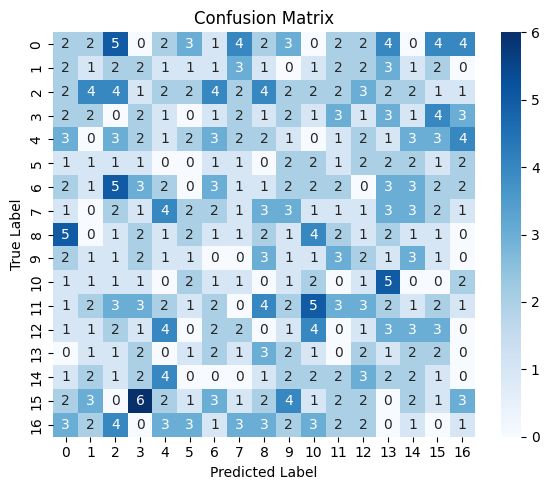

Brier Score (macro-average): 1.0142


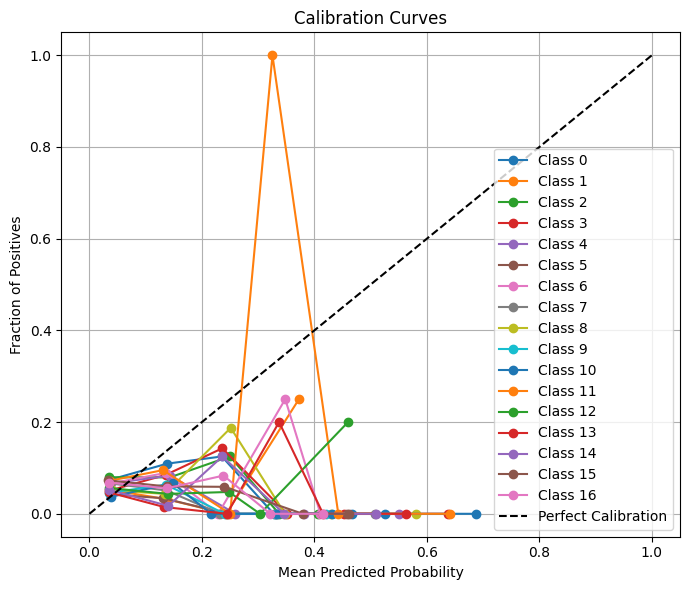

In [91]:
# Install seaborn if not already installed
!pip install seaborn --quiet

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, roc_curve, auc

# === Simulated Data (REPLACE with actual model output) ===
num_classes = 17  # change as needed
np.random.seed(42)
y_val_true = np.random.randint(0, num_classes, size=500)     # True labels (shape: [500])
logits = np.random.randn(500, num_classes)                    # Simulated logits from model

# === Calibrated probabilities after Temperature Scaling ===
calibrated_probs = tf.nn.softmax(logits, axis=1).numpy()      # Shape: (500, num_classes)

# === Predicted Labels ===
y_pred = np.argmax(calibrated_probs, axis=1)



# === Confusion Matrix ===
cm = confusion_matrix(y_val_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# === Brier Score ===
y_true_bin = tf.keras.utils.to_categorical(y_val_true, num_classes=num_classes)
brier_score = np.mean(np.sum((y_true_bin - calibrated_probs) ** 2, axis=1))
print(f"Brier Score (macro-average): {brier_score:.4f}")

# === Calibration Plot ===
plt.figure(figsize=(7, 6))
for i in range(num_classes):
    if np.sum(y_true_bin[:, i]) == 0:
        continue  # Skip if no positive examples for this class
    prob_true, prob_pred = calibration_curve(y_true_bin[:, i], calibrated_probs[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {i}')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.title("Calibration Curves")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
